### MINST-Digit Recognizer

This Notebook is for only training the model, testing model accuracy with hyperparameters, this is not for EDA.

In [180]:
import pandas as pd
import numpy as np
import torch

import os

from sklearn.model_selection import train_test_split
import torch.nn as nn   
import torch.nn.functional as F
from torchvision  import datasets 
from torch.utils.data import Dataset,DataLoader ,ConcatDataset
import torchvision.transforms as transform
import matplotlib.pyplot as plt

from torch.utils.data import random_split


Data is downloaded from Kaggle Dataset, link :https://www.kaggle.com/c/digit-recognizer/data <br>
`train.csv` and `test.csv` are extracted to path `notebooks\data` path

Loading Dataset

In [160]:
train_df = pd.read_csv(os.path.join("notebooks","data","train.csv"))
test_df = pd.read_csv(os.path.join("notebooks","data","test.csv"))


In [161]:
image_size = 28


In [162]:
train_df.head(5)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [163]:
train_df.label.unique()


array([1, 0, 4, 7, 3, 5, 8, 9, 2, 6])

Plotting Images

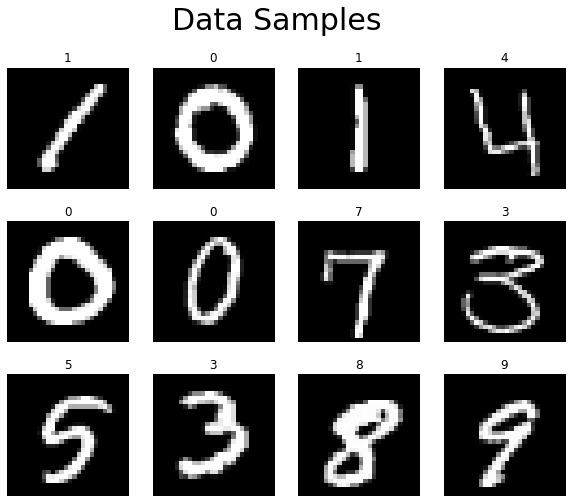

In [164]:
nrows = 3
ncols = 4
fig, axes = plt.subplots(nrows,ncols,figsize=(10,8))
i=0

for row in range(nrows):
    for col in range(ncols):
        axes[row][col].imshow(train_df.iloc[i,1:].values.reshape(28,28),cmap='gray')
        axes[row][col].set_title(train_df.iloc[i,0])
        axes[row][col].axis('off')
        i+=1

plt.suptitle('Data Samples', fontsize=30)
plt.show()


Custom Dataset Class

In [165]:
class customDatasetClass(Dataset):
    def __init__(self, features, labels, Transform):
        self.x = features
        self.y = labels
        self.transform = Transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.transform(self.x[index]), self.y[index]


In [166]:
def GetDf(df, Transform):
  x_features = df.iloc[:, 1:].values
  y_labels = df.label.values
  x_features = x_features.reshape(-1, 1, 28, 28)
  x_features = np.uint8(x_features)
  x_features = torch.from_numpy(x_features)
  y_labels = torch.from_numpy(y_labels)
  return customDatasetClass(x_features, y_labels, Transform)


In [265]:
transformer = {
 '0': transform.Compose([
                           transform.ToPILImage(),
                           transform.Resize(image_size),
                        #    transform.Grayscale(num_output_channels=3), 
                           transform.ToTensor(),
                           transform.Normalize(
                                    [0.13097111880779266],
                                    [0.30848443508148193])
]),

    '1': transform.Compose([
                           transform.ToPILImage(),
                           transform.Resize(image_size),
                        #    transform.Grayscale(num_output_channels=3),
                           transform.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                           transform.RandomRotation(5),
                           transform.RandomAffine(degrees=11, translate=(0.1,0.1), scale=(0.8,0.8)),
                           transform.ToTensor(),
                           transform.Normalize(
                                    [0.13097111880779266],
                                    [0.30848443508148193])
]),
    'val': transform.Compose([
                           transform.ToPILImage(),
                           transform.Resize(image_size),
                        #    transform.Grayscale(num_output_channels=3),
                           transform.ToTensor(),
                           transform.Normalize(
                                  [0.13141274452209473],
                                  [0.30904173851013184])
    ])
}


In [266]:
use_cuda = False
print(use_cuda)


False


In [267]:
class TestDataset(Dataset):
    def __init__(self, features,transform=transform.Compose([
                              transform.ToPILImage(),
        transform.Resize(image_size),
        # transform.Grayscale(num_output_channels=3),
                              transform.ToTensor(),
                              transform.Normalize(
                                  [0.13141274452209473],
                                  [0.30904173851013184])
    ])):
        self.features = features.values.reshape((-1,28,28)).astype(np.uint8)
        self.targets = None
        self.transform=transform
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        return self.transform(self.features[idx])


In [268]:
def create_dataloaders(seed, test_size=0.1, df=train_df, batch_size=64):
    
    # Create training set and validation set
    train_data, valid_data = train_test_split(df,
                                              test_size=test_size,
                                              random_state=seed)
    
    # Create Datasets
    train_dataset_0 = GetDf(train_data, Transform=transformer['0'])
    train_dataset_1 = GetDf(train_data, Transform=transformer['1'])
    
    train_dataset = ConcatDataset([train_dataset_0, train_dataset_1])

    valid_dataset = GetDf(valid_data, Transform=transformer['val'])
    
    # Create Dataloaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, num_workers=4)

    train_size = len(train_dataset)
    val_size = len(valid_dataset)

    return train_loader, valid_loader, train_size, val_size


In [269]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}


In [270]:
train_loader, valid_loader, train_size, val_size = create_dataloaders(54,test_size=0.3)


In [271]:
test_image = next(iter(train_loader))
print(f"Shape of image {test_image[0].shape}, Labels are {len(test_image[1])}")


Shape of image torch.Size([64, 1, 28, 28]), Labels are 64


Model

In [272]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128, 10),
        )
                
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = x.view(x.size(0), -1)
        return F.log_softmax(x)

model = Net()
print(model)


Net(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p

In [273]:
optimizer = torch.optim.Adam(lr=0.001,params= model.parameters())
criterion  = nn.CrossEntropyLoss()


In [274]:
from tqdm import tqdm


In [277]:
num_epochs = 10
train_loss = []
test_loss = []
train_accuracy = []
test_accruacy = []
for epoch in range(num_epochs):
    for batch_idx,(data,target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(target.squeeze(),output)
        loss.backward()
        optimizer.step()
        

/tmp/ipykernel_2170/188213895.py:46: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


RuntimeError: "log_softmax_lastdim_kernel_impl" not implemented for 'Long'

In [ ]:
len(train_loader)


919